In [1]:


import pandas as pd
import mysql
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import mysql
from mysql.connector import MySQLConnection, Error
import time
from datetime import datetime, time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load





from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
df = pd.DataFrame()
def query_with_fetchall():
    try:
        connection = mysql.connector.connect(user='brett', 
                                             password='BrettTully#2023',
                                             host='r2klabs.com',
                                             database='sensor')
        cursor = connection.cursor()
        cursor.execute("SELECT * FROM rpisense order by sensor_date DESC;")
        rows = cursor.fetchall()
        print('Total Row(s):', cursor.rowcount)
        title = [i[0] for i in cursor.description]
        print(title)
        global df
        df = pd.DataFrame(rows)
        df['time'] = df[1].dt.time
        df['weekday'] = df[1].dt.weekday
        df['date'] = df[1].dt.date
        #df.to_csv("sensordata.csv",index=False)
    except Error as e:
        print(e)
    finally:
        cursor.close()
        connection.close()
query_with_fetchall()

df.rename(columns={0:"Device",1:"Datetime",2:"Temp F",3:"Humidity","time":"Time","weekday":"Weekday","date":"Date"},inplace=True)        



################## Creating the dictionary that contains the class times  ################################################################################


occupied_times = {
    "P002": {
        "0": [("09:00:00","09:50:00"),("10:00:00","10:50:00") ,("13:00:00","13:50:00")],
        "1": [("09:00:00", "11:00:00"),("12:15:00","13:30:00")],
        "2": [("09:00:00","9:50:00"),("10:00:00","10:50:00"), ("13:00:00","13:50:00")],
        "3": [("11:00:00","12:15:00"),("13:30:00","15:40:00")],
        "4": [("09:00:00","09:50:00"),("10:00:00","10:50:00")]
    },
    "P004": {
        "0": [("09:00:00","09:50:00"),("10:00:00","10:50:00")],
        "1": [("08:40:00","10:40:00"),("12:15:00", "13:30:00"), ("13:40:00","14:50:00")],
        "2": [("09:00:00","09:50:00"),("10:00:00","10:50:00")],
        "3": [("08:40:00","10:40:00"),("12:15:00", "13:30:00"),("13:40:00","14:50:00")],
        "4": [("09:00:00","09:50:00"),("10:00:00","10:50:00")]
    },
    "P006B": {
        "1": [("10:00:00", "12:00:00")],
        "2": [("10:00:00", "12:00:00")],
        "3": [("10:00:00", "12:00:00")],
        "4": [("10:00:00", "12:00:00")],
        "5": [("10:00:00", "12:00:00")]
    }
}

flattened = []



# turning the dictionary into a dataframe

for room, room_sessions in occupied_times.items(): 
    for dow, session_windows in room_sessions.items():
        for session_window in session_windows: 
            flattened.append([room,dow,session_window[0],
                             session_window[1]])
room_times = pd.DataFrame(flattened, columns =['Device','Weekday','Start Time','End Time'])           
room_times.to_csv('room_times.csv')


df = df.reset_index(drop=True)
room_times = room_times.reset_index(drop=True)

df = df.sample(1000)

df['Time'] = df['Time'].astype(str)
df['Device'] = df['Device'].astype(str)
room_times['Weekday'] = room_times['Weekday'].astype('int64')
room_times['Start Time'] = room_times['Start Time'].astype(str)
room_times['End Time'] = room_times['End Time'].astype(str)
room_times['Device'] = room_times['Device'].astype(str)




############MODEL################################################################################

Total Row(s): 4939900
['device', 'sensor_date', 'temp', 'humidity']


# Assigning a 1 or 0 based on whether the class was actually in session

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Convert start_time and end_time columns to time objects
room_times['Start Time'] = room_times['Start Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
room_times['End Time'] = room_times['End Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())




# Convert time_stamp column to time objects and check if it falls between any of the time ranges on the specified days of the week and room numbers
df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())

# Create new columns in the time_stamps_df DataFrame called 'in_range' and 'room_number', and initialize them to 0 and None, respectively
df['in_use'] = 0


# Iterate through each row in the time_stamps_df DataFrame, and for each row we iterate through each row in the df DataFrame to check if the time stamp falls between any of the time ranges on the specified days of the week and room numbers. If the time stamp falls between any of the time ranges on the specified day of the week and room number, we set the value of 'in_range' to 1 and the value of 'room_number' to the corresponding room number using the at() method.

for index, row in df.iterrows():
    for index2, row2 in room_times.iterrows():
        if row2['Weekday'] == row['Weekday'] and row2['Device'] == row['Device']:
            if row2['Start Time'] <= row['Time'] <= row2['End Time']:
                df.at[index, 'in_use'] = 1
                break       


                
                
             

# Grid Search Model

In [4]:


# Preprocess data


df['Temp F'] = df['Temp F'].fillna(df['Temp F'].mean())

# Split into features and target
X = df[['Humidity', 'Temp F','Weekday']]
y = df['in_use']

# Define models and parameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'clf__penalty': ['l1', 'l2', 'elasticnet',None],
            'clf__C': [0.1, 1, 10],
            'clf__solver': ['saga', 'liblinear','lbfgs','sag','newton-cg']
           
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'clf__criterion': ['gini', 'entropy'],
            'clf__max_depth': [None, 5, 10,15,20],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [50, 100, 150,300,500],
            'clf__max_depth': [None, 5, 10,50,100],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    }
}

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

# Perform grid search CV
best_model = None
best_score = 0

for model_name, model_params in models.items():
    print('Running grid search for:', model_name)
    model_pipeline = pipeline.set_params(clf=model_params['model'])
    grid_search = GridSearchCV(model_pipeline, model_params['params'], cv=5, scoring='accuracy',verbose=3)
    grid_search.fit(X, y)
    print('Best parameters:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_)
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = model_name


print('Best model:', best_model)

Running grid search for: Logistic Regression
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END clf__C=0.1, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=0.1, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=0.1, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=0.1, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=0.1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=0.1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=0.1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=0.1, clf__penalty=l1, clf

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

[CV 5/5] END clf__C=0.1, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=0.1, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=0.1, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=0.1, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=0.1, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=0.1, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=0.1, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=0.1, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=0.1, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=0.1, clf__penalty=None, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

[CV 3/5] END clf__C=1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=1, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=1, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END clf__C=1, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END clf__C=1, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END clf__C=1, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END clf__C=1, clf__penalty=l1, clf__solver=sag;, score=nan total time=   0.0s
[CV 2/5] END clf__C=1, clf__penalty=l1, clf__solver=sag;, score=nan total time=   0.0s
[CV 3/5] END clf__C=1, clf__penalty=l1, clf__solver=sag;, score=nan total time=   0.0s
[CV 4/5] 

[CV 5/5] END clf__C=10, clf__penalty=l1, clf__solver=saga;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=10, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=10, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=10, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=10, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=10, clf__penalty=l1, clf__solver=liblinear;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=10, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END clf__C=10, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END clf__C=10, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END clf__C=10, clf__penalty=l1, clf__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END clf__C=10, clf__penalty=l1, clf__solver=lbfgs;, score=na

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

[CV 3/5] END clf__C=10, clf__penalty=None, clf__solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END clf__C=10, clf__penalty=None, clf__solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END clf__C=10, clf__penalty=None, clf__solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END clf__C=10, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=10, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=10, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 4/5] END clf__C=10, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=10, clf__penalty=None, clf__solver=lbfgs;, score=0.920 total time=   0.0s
[CV 1/5] END clf__C=10, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 2/5] END clf__C=10, clf__penalty=None, clf__solver=sag;, score=0.920 total time=   0.0s
[CV 3/5] END clf__C=10, clf__penalty=None, clf__solver=sag

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

[CV 4/5] END clf__C=10, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
[CV 5/5] END clf__C=10, clf__penalty=None, clf__solver=newton-cg;, score=0.920 total time=   0.0s
Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best score: 0.9200000000000002
Running grid search for: Decision Tree
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1;, score=0.890 total time=   0.0s
[CV 2/5] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1;, score=0.830 total time=   0.0s
[CV 3/5] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1;, score=0.885 total time=   0.0s
[CV 4/5] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1;, score=0.885 total time=   0.0s
[CV 5/5] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1;, score=0.860 total time=   0.0s
[CV 1/5] END clf__criterion=gini, 

[CV 5/5] END clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=5;, score=0.885 total time=   0.0s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1;, score=0.920 total time=   0.0s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1;, score=0.910 total time=   0.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1;, score=0.915 total time=   0.0s
[CV 4/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1;, score=0.915 total time=   0.0s
[CV 5/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1;, score=0.910 total time=   0.0s
[CV 1/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2;, score=0.920 total time=   0.0s
[CV 2/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2;, score=0.920 total time=   0.0s
[CV 3/5] END clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2;, score=0.920 total ti

[CV 1/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.905 total time=   0.3s
[CV 2/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.895 total time=   0.3s
[CV 3/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.925 total time=   0.3s
[CV 4/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.915 total time=   0.3s
[CV 5/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.910 total time=   0.3s
[CV 1/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.890 total time=   0.6s
[CV 2/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.900 total time=   0.6s
[CV 3/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.920 total time=   0.6s
[CV 4/5] END clf__max_depth=None, clf__min_samples_leaf=1, clf__n_estimators=300;, score

[CV 4/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.3s
[CV 5/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.2s
[CV 1/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 2/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 3/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 4/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 5/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 1/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.920 total time=   0.6s
[CV 2/5] END clf__max_depth=5, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.920 total time=   0.8s
[

[CV 3/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.915 total time=   0.3s
[CV 4/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.2s
[CV 5/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.925 total time=   0.2s
[CV 1/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.915 total time=   0.3s
[CV 2/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.915 total time=   0.3s
[CV 3/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.915 total time=   0.3s
[CV 4/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.4s
[CV 5/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 1/5] END clf__max_depth=10, clf__min_samples_leaf=1, clf__n_estimators=300;, score=0.920 total time=

[CV 2/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.890 total time=   0.2s
[CV 3/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.3s
[CV 4/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.915 total time=   0.3s
[CV 5/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.2s
[CV 1/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.900 total time=   0.3s
[CV 2/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.900 total time=   0.3s
[CV 3/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.925 total time=   0.3s
[CV 4/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 total time=   0.3s
[CV 5/5] END clf__max_depth=50, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.910 total time=

[CV 1/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.905 total time=   0.3s
[CV 2/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.890 total time=   0.3s
[CV 3/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.3s
[CV 4/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.920 total time=   0.3s
[CV 5/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=100;, score=0.910 total time=   0.3s
[CV 1/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.900 total time=   0.4s
[CV 2/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.895 total time=   0.4s
[CV 3/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.925 total time=   0.4s
[CV 4/5] END clf__max_depth=100, clf__min_samples_leaf=1, clf__n_estimators=150;, score=0.920 to

# Confusion Matrix

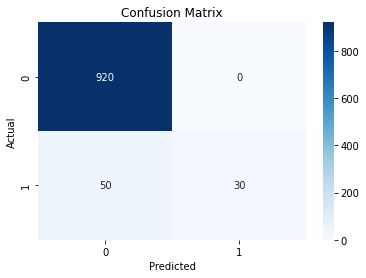

<Figure size 432x288 with 0 Axes>

In [5]:
y_pred = grid_search.predict(X)

# Create a confusion matrix
conf_mat = confusion_matrix(y, y_pred)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.savefig('confusion_matrix.png')

### back ups in case anything got deleted

# Logistic Regression

In [9]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your column and transform the data
encoded_column = label_encoder.fit_transform(df['Device'])

# Replace the old column with the encoded column in your dataframe
#df['Device'] = encoded_column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Weekday','Temp F','Humidity']], df['in_use'], test_size=0.4, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)
# Get probability estimates for each class
proba = model.predict_proba(X_test)

# Get probability for positive class (in_use = 1)
pos_proba = proba[:, 1]

# Create new column in test set for predicted probability
X_test['pred_proba'] = pos_proba

# Calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Add performance metrics to the dataframe
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.91
Accuracy: 0.91
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


# Models again, working on making predictions for the next 30 minutes

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your column and transform the data
encoded_column = label_encoder.fit_transform(df['Device'])

# Replace the old column with the encoded column in your dataframe
df['Device'] = encoded_column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Weekday','Device','Temp F','Humidity']], df['in_use'], test_size=0.2, random_state=42)

# Initialize and train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)


# Calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.92
